# Week 6 - Regularized Linear Regression and Bias vs. Variance

In this exercise, we're looking at a dataset containing historical records on the change in water level and the amount of water flowing out of a dam. The data has been pre-partitioned into training, cross-validation, and test sets.

## Regularized Linear Regression

First, we will perform a regularized linear regression on our data to see how it performs.

### Visualizing the Data

Let's first load and have a look at the data.

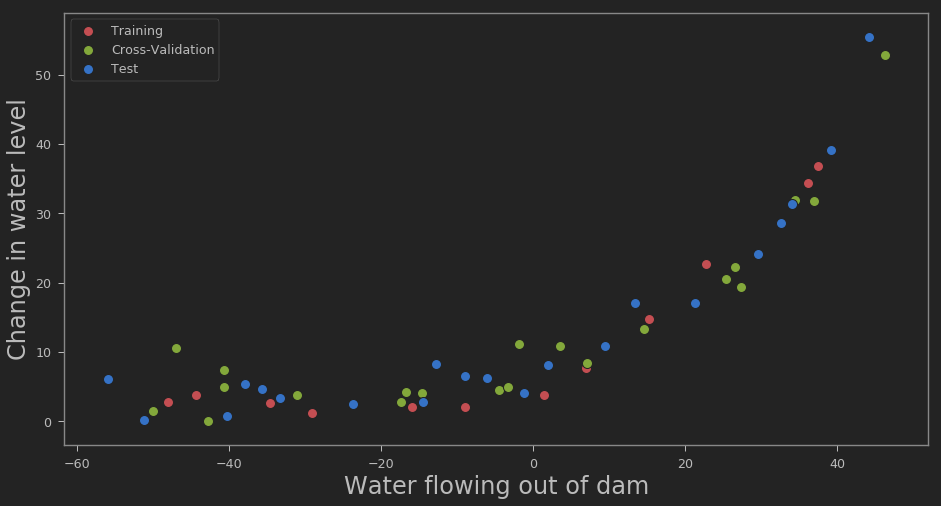

In [13]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import optimize
import warnings
warnings.filterwarnings('ignore')
from jupyterthemes import jtplot
jtplot.style(theme='monokai',context='notebook',ticks=True,grid=False)

# Set the data path
dataDir = "./assignment/ex5/"
dataFile = "ex5data1.mat"
dataPath = dataDir+dataFile

# Load the data
data = loadmat(dataPath)
X = data['X']
y = data['y']
XVal = data['Xval']
yVal = data['yval']
XTest = data['Xtest']
yTest = data['ytest']

# Create the plot of the data
fig = plt.figure(figsize=(12,6));
ax = fig.add_axes([0,0,1,1]);
ax.scatter(X,y,color='r',marker="o",edgecolor="k",linewidth=1,s=100);
ax.scatter(XVal,yVal,color='g',marker="o",edgecolor="k",linewidth=1,s=100);
ax.scatter(XTest,yTest,color='b',marker="o",edgecolor="k",linewidth=1,s=100);
ax.set_xlabel('Water flowing out of dam',fontsize=24);
ax.set_ylabel('Change in water level',fontsize=24);
ax.legend(("Training","Cross-Validation","Test"));

### Regularized Cost Function and Gradients

Since we need to minimize the cost function using a minimization technique, we need to create functions that will calculate the cost function and the gradients. We're doing a linear regression, so recall that the regularized linear regression cost function is

$$ J( \theta ) = \frac{1}{2 m} \Big( \sum_{i=1}^m \big( h_\theta (x^{(i)}) - y^{(i)} \big)^2 \Big) +
               \frac{\lambda}{2 m} \Big( \sum_{j=1}^n \theta_j^{2} \Big) $$
               
and the gradients are

$$ \begin{align}
   \frac{\partial J (\theta)}{\partial \theta_0} & = \frac{1}{m} \sum_{i=1}^{m} 
   \big( h_\theta (x^{(i)}) - y^{(i)} \big) & \text { for } j = 0 \\
   \frac{\partial J (\theta)}{\partial \theta_j} & = \frac{1}{m} \sum_{i=1}^{m} 
   \big( h_\theta (x^{(i)}) - y^{(i)} \big) x_j + \frac{\lambda}{m} \theta_j & \text { for } j \geq 1
\end{align} $$

So let's create those functions now.

In [79]:
def add_col_ones(X):
    
    """Add a column of ones to an array"""
    # Get the shape
    m = X.shape[0]
    
    return np.concatenate((np.ones((m,1)),X),axis=1)

def cost_function(theta,X,y,regCoeff):
    
    """Calculate the cost function with regularization for a linear regression"""
    
    # Cast arrays as matrices
    X = np.matrix(X)
    y = np.matrix(y)
    theta = np.matrix(theta).T
    
    # Get number of samples
    m = X.shape[0]
    
    # Evaluate hypothesis function
    h = X*theta
    
    # Calculate the cost function
    J = (1./(2.*m))*(h-y).T*(h-y)
    
    # Add regularization and return
    return J + (regCoeff/(2*m))*(theta[1:].T*theta[1:])

def gradient(theta,X,y,regCoeff):
    
    """Calculate the gradient regularization for a linear regression"""
    
    # Cast arrays as matrices
    X = np.matrix(X)
    y = np.matrix(y)
    theta = np.matrix(theta).T
    
    # Get number of samples
    m = X.shape[0]
    
    # Evaluate hypothesis function
    h = X*theta
    
    # Calculate the gradient
    grad = (1./m)*X.T*(h-y)
    
    # Add regularization and return
    grad[1:] = grad[1:]+((regCoeff/m)*theta[1:])
    return grad

### Fitting the Linear Regression

Now let's minimize our linear regression parameters to get a best-fit line. Let's first create a function to train the linear regression. Note that we don't actually need to use the gradient function to minimize with the scipy optimize module

In [173]:
def train_linear_reg(X,y,regCoeff):

    """Train the linear regression with a minimization function"""

    # Initialize parameters
    n = X.shape[1]
    theta = np.zeros((n,1))

    # Run the minimization function
    fmin = optimize.fmin_tnc(func=cost_function,x0=theta,fprime=gradient,args=(X,y,regCoeff))
    
    return fmin[0]

Now let's train the model and see how it compares to the data

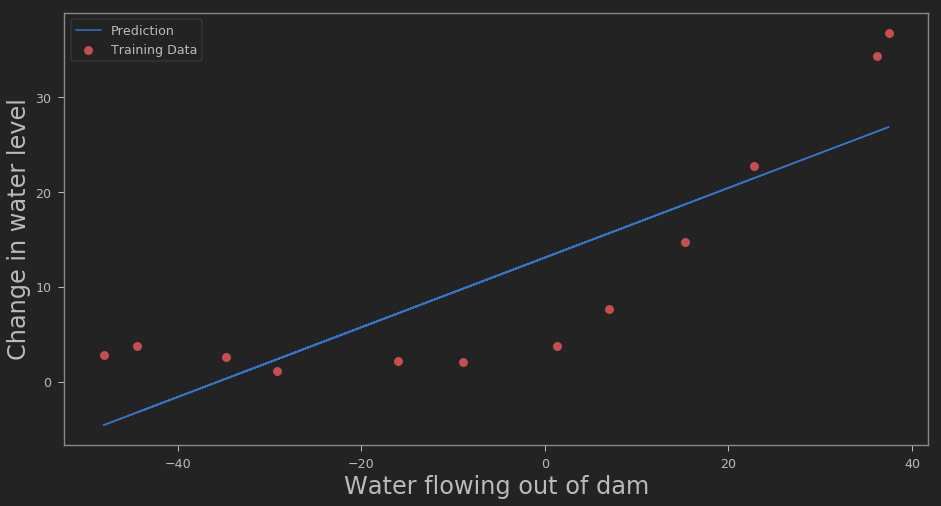

In [174]:
# Train the linear regression and find parameters
theta = train_linear_reg(add_col_ones(X),y,0)

# Calculate predicted output
predicted = np.matmul(add_col_ones(X),theta)

# Create the plot of the data
fig = plt.figure(figsize=(12,6));
ax = fig.add_axes([0,0,1,1]);
ax.scatter(X,y,color='r',marker="o",edgecolor="k",linewidth=1,s=100);
ax.plot(X,predicted,color='b');
ax.set_xlabel('Water flowing out of dam',fontsize=24);
ax.set_ylabel('Change in water level',fontsize=24);
ax.legend(("Prediction","Training Data"));

We can see from here that maybe a straight line is not the greatest fit. Later, we'll try out higher degree polynomials.

## Bias vs. Variance

An important concept in machine learning is the bias-variance tradeoff. Models with high bias are not complex enough for the data and tend to underfit, while models with high variance overfit to the training data. In this part of the exercise, we plot training and test errors on a learning curve to diagnose bias/variance problems.

### Learning Curves

To create our learning curve, we need to implement the training on training sets of different sizes and compare to the full cross-validation data set. So let's create a function where we can step through different sizes of the training set and calculate our errors. Note that we need to compare the errors *without* regularization.

In [175]:
def learning_curve(X,y,XVal,yVal,regCoeff):
    
    """Calculate errors for vary sizes of the training dataset"""
    
    # Get the number of training samples
    m = X.shape[0]
    
    # Initialize lists
    errorTrain = []
    errorVal = []
    
    # Loop through training set sizes
    for i in range(1,m+1):
        theta = train_linear_reg(add_col_ones(X[0:i]),y[0:i],regCoeff)
        errorTrain.append(cost_function(theta,add_col_ones(X[0:i]),y[0:i],0))
        errorVal.append(cost_function(theta,add_col_ones(XVal),yVal,0))
        
    return np.array(errorTrain).flatten(),np.array(errorVal).flatten()

Now let's calculate the error and plot the learning curves

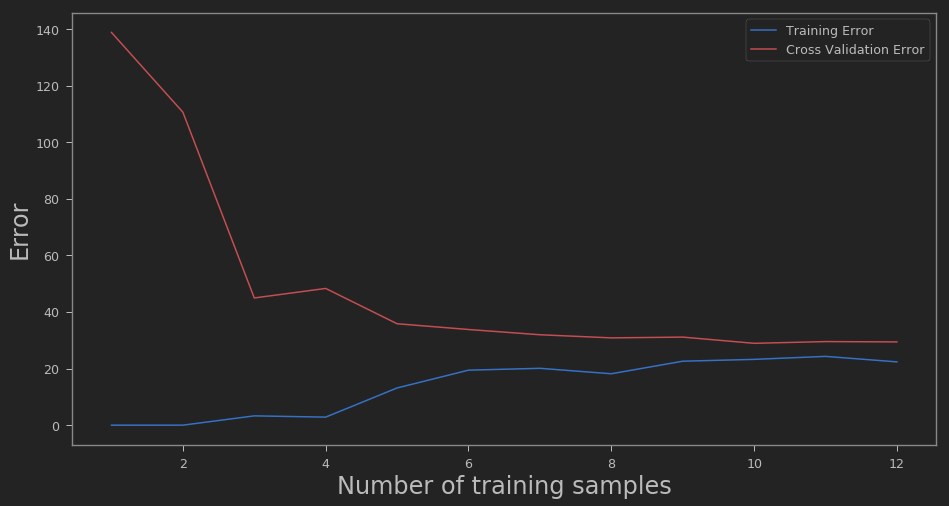

In [176]:
# Get the errors
errorTrain,errorVal = learning_curve(X,y,XVal,yVal,1)

# Create the plot of the data
fig = plt.figure(figsize=(12,6));
ax = fig.add_axes([0,0,1,1]);
ax.plot(np.linspace(1,m,m),errorTrain,color='b');
ax.plot(np.linspace(1,m,m),errorVal,color='r');
ax.set_xlabel('Number of training samples',fontsize=24);
ax.set_ylabel('Error',fontsize=24);
ax.legend(("Training Error","Cross Validation Error"));

Both the training and cross validation error are high, indicating high-bias.

## Polynomial Regression

Our linear model was too simple for the data we have, giving us high bias. So let's increase the complexity of the model by adding a higher order polynomial.  Let's first create a function that computes these higher order powers.

In [177]:
def polynomial_features(X,p):

    """For a given array, return larger matrix containing polynomial powers of the array"""
    
    # Recast as matrix
    X = np.matrix(X)
    
    # Initialize array
    XPoly = np.zeros((X.size,p));
    
    # Loop through degrees and add elements into array
    for i in range(0,p):
        XPoly[:,i] = np.matrix(np.power(X,i+1).T)
    
    return XPoly

Since these values vary quite drastically, it helps to normalize them. After calculting the higher order polynomials, we'll normalize the training, validation, and test sets all on the training set mean and standard deviation.

In [203]:
# Get the higher order powers of all three sets
degree = 8
XPoly = polynomial_features(X,degree)
XValPoly = polynomial_features(XVal,degree)
XTestPoly = polynomial_features(XTest,degree)

# Get the mean and standard deviation of the training set
mu = XPoly.mean(axis=0)
sigma = XPoly.std(axis=0)

# Normalize the data sets
XPoly = (XPoly-mu)/sigma
XPoly = add_col_ones(XPoly)
XValPoly = (XValPoly-mu)/sigma
XValPoly = add_col_ones(XValPoly)
XTestPoly = (XTestPoly-mu)/sigma
XTestPoly = add_col_ones(XTestPoly)

Now let's train the model and plot the results

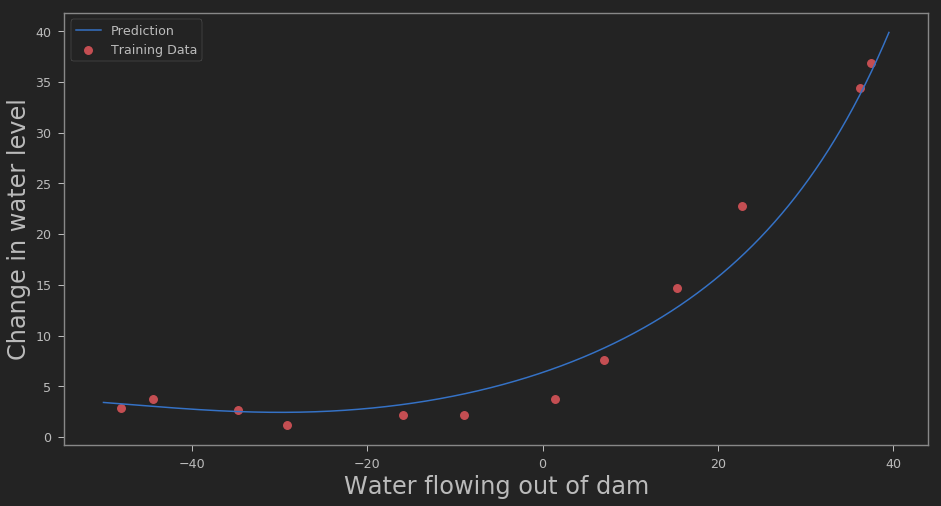

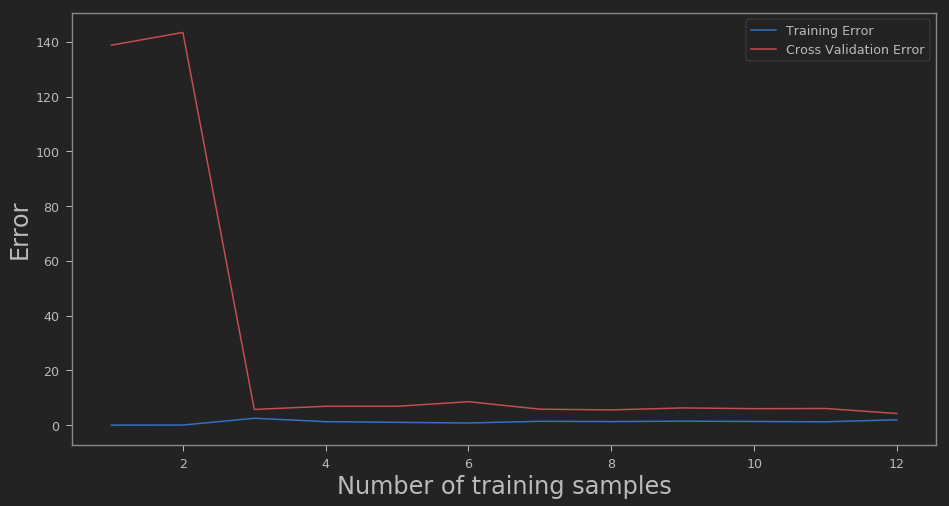

In [215]:
# Train the model with regression coeffecient set to 0
theta = train_linear_reg(XPoly,y,1)
x = np.arange(X.min() - 2, X.max() + 2, 0.05).reshape(-1, 1)
x_poly = polynomial_features(x,degree)
x_poly -= mu
x_poly /= sigma
x_poly = add_col_ones(x_poly)
predicted = np.matmul(x_poly,theta)

# Plot to show the model prediction
fig = plt.figure(figsize=(12,6));
ax = fig.add_axes([0,0,1,1]);
ax.scatter(X,y,color='r',marker="o",edgecolor="k",linewidth=1,s=100);
ax.plot(x,predicted,color='b');
ax.set_xlabel('Water flowing out of dam',fontsize=24);
ax.set_ylabel('Change in water level',fontsize=24);
ax.legend(("Prediction","Training Data"));

# Get the errors
errorTrain,errorVal = learning_curve(XPoly,y,XValPoly,yVal,1)

# Create the plot of the data
fig = plt.figure(figsize=(12,6));
ax = fig.add_axes([0,0,1,1]);
ax.plot(np.linspace(1,m,m),errorTrain,color='b');
ax.plot(np.linspace(1,m,m),errorVal,color='r');
ax.set_xlabel('Number of training samples',fontsize=24);
ax.set_ylabel('Error',fontsize=24);
ax.legend(("Training Error","Cross Validation Error"));

### Selecting the Regression Coeffecient across the Validation Set

The value of our regularization coefficient can significantly affect the results of the regression. If we select a small regularization coefficient, we overfit the data and fail to generalize beyond the training dataset well, but a very large value will fail to fit the training *and* test dataset. We can use the cross-validation set to figure out a good choice for our regularization coefficient. In the function below, we'll establish a set of coefficients to test, then return the training and validation error.

In [225]:
def validation_curve(X,y,XVal,yVal):

    """Check a set of regularization coefficients and provide the error for each on the training 
       and validaiton datasets"""
    
    # Set a range of regularization coefficients
    regCoeffList = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
    
    # Initialize arrays
    errorTrain = []
    errorVal = []
    
    # Loop through coefficients
    for regCoeff in regCoeffList:
        theta = train_linear_reg(add_col_ones(X),y,regCoeff)
        errorTrain.append(cost_function(theta,add_col_ones(X),y,0))
        errorVal.append(cost_function(theta,add_col_ones(XVal),yVal,0))
        
    return np.array(regCoeffList).flatten(),\
           np.array(errorTrain).flatten(),\
           np.array(errorVal).flatten()

Now let's run the function and plot the results to see the best coefficient choice.

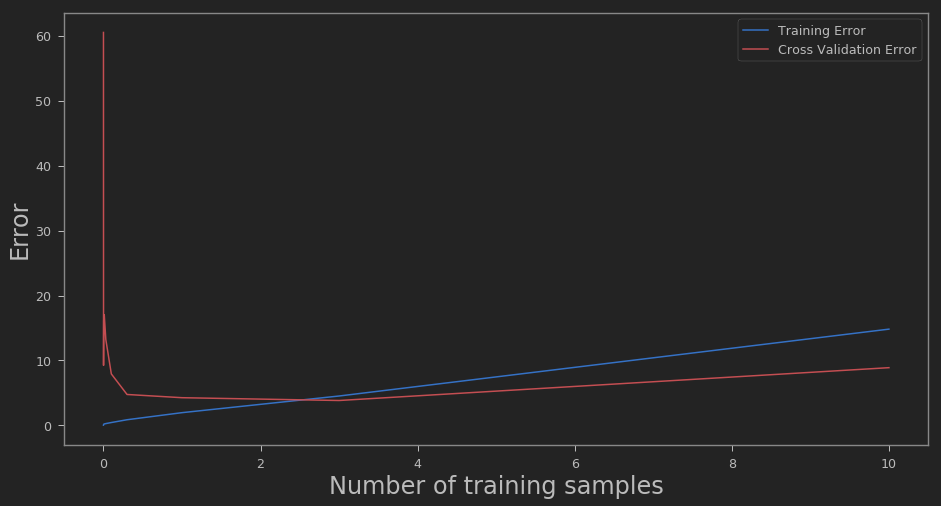

In [226]:
regCoeffList,errorTrain,errorVal = validation_curve(XPoly,y,XValPoly,yVal)

# Create the plot of the data
fig = plt.figure(figsize=(12,6));
ax = fig.add_axes([0,0,1,1]);
ax.plot(regCoeffList,errorTrain,color='b');
ax.plot(regCoeffList,errorVal,color='r');
ax.set_xlabel('Number of training samples',fontsize=24);
ax.set_ylabel('Error',fontsize=24);
ax.legend(("Training Error","Cross Validation Error"));

So it appears that a regularization coefficient of about 3 is a good choice. Finally, let's go back and use this coefficient and plot the results.

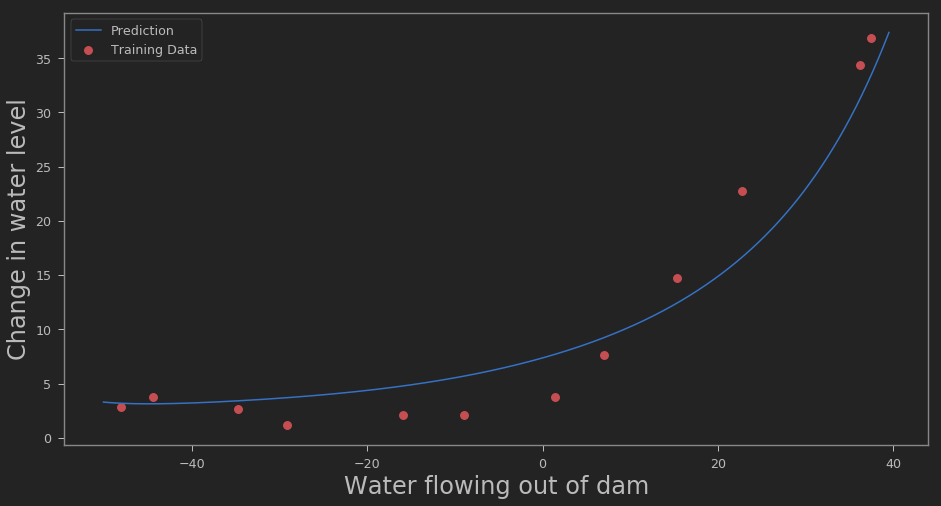

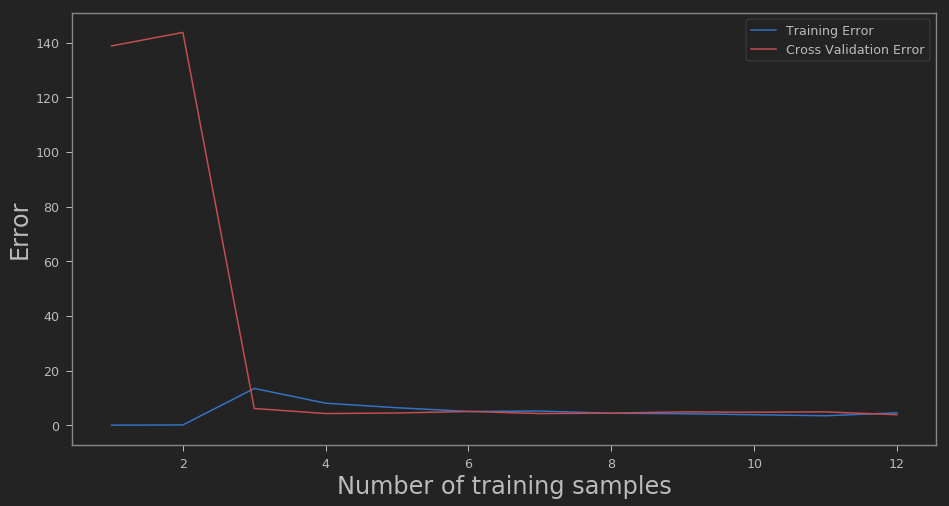

In [229]:
# Train the model with regression coeffecient set to 0
theta = train_linear_reg(XPoly,y,3)
x = np.arange(X.min() - 2, X.max() + 2, 0.05).reshape(-1, 1)
x_poly = polynomial_features(x,degree)
x_poly -= mu
x_poly /= sigma
x_poly = add_col_ones(x_poly)
predicted = np.matmul(x_poly,theta)

# Plot to show the model prediction
fig = plt.figure(figsize=(12,6));
ax = fig.add_axes([0,0,1,1]);
ax.scatter(X,y,color='r',marker="o",edgecolor="k",linewidth=1,s=100);
ax.plot(x,predicted,color='b');
ax.set_xlabel('Water flowing out of dam',fontsize=24);
ax.set_ylabel('Change in water level',fontsize=24);
ax.legend(("Prediction","Training Data"));

# Get the errors
errorTrain,errorVal = learning_curve(XPoly,y,XValPoly,yVal,3)

# Create the plot of the data
fig = plt.figure(figsize=(12,6));
ax = fig.add_axes([0,0,1,1]);
ax.plot(np.linspace(1,m,m),errorTrain,color='b');
ax.plot(np.linspace(1,m,m),errorVal,color='r');
ax.set_xlabel('Number of training samples',fontsize=24);
ax.set_ylabel('Error',fontsize=24);
ax.legend(("Training Error","Cross Validation Error"));